## Introduction

This project replicates the counterfactual part of Multidimensional Auctions of Contracts: An Empirical Analysis by Yunmi Kong, Isabelle Perrigne, and Quang Vuong published in American Economics Review in 2022. This paper analyzes cash-royalty auctions of Louisiana oil leases. In this auction, the bidders bid for a one-time cash payment and royalty (the proportion of revenues they will pay the government afterward). The winner of the auction has the right of drilling, but it is not compulsory. They model this auction as a private value auction in which each bidder draws a private productivity level $\theta_1$ and a private cost $\theta_2$ of drilling $ from a joint distribution. The private value also depends on the oil price, which is modeled as a geometric Brownian motion. I will include more details of their auction model in this notebook.

This paper estimates the joint distribution of $\theta_1$ and $\theta_2$ non-parametrically and analyzes counterfactuals based on that. However, in my replication, I skip the estimation part and do the counterfactual only. First, I simulate $\theta_1$ and $\theta_2$ and compute the private values and bids for each firm. Then, I simulate the expected revenues of the government under different scenarios as follows.
1. The auction has flexible royalty.
2. The auctions have fixed royalty.
3. The government has different rules for selecting the winner.
4. The oil price increases.


## Replication
### Generate Fake Parameters

In [32]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from turtle import color
from matplotlib.pyplot import xlabel
from scipy.stats import multivariate_normal
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

numB = 1000     # number of bidders
numA = 100     # number of auctions

THETA1 =  np.maximum(0.1, np.exp(np.random.normal(size=numB)))

# when THETA2 is standard normal times 12, the mean of THETA2/THETA1 is close to 21
#   the is the average cost per barrel.
THETA2 =  12 * np.minimum(10,np.exp(np.random.normal(scale=0.5, size=numB)))

Discriptive Statistics of the Fake Parameters. $\theta_1 / \theta_2$ is the average cost per barrel.

Text(0, 0.5, 'Density')

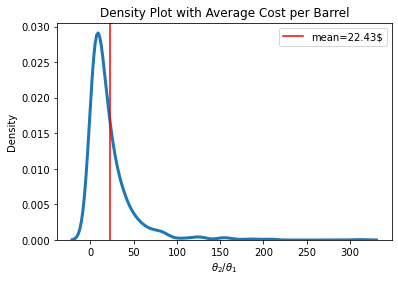

In [31]:
from turtle import color
from matplotlib.pyplot import xlabel
sns.distplot(THETA2/THETA1, hist = False, kde = True, kde_kws = {'linewidth': 3})
plt.axvline(x=np.mean(THETA2/THETA1),color='red', label='mean=' + str(round(np.mean(THETA2/THETA1),2)) + '$')
plt.legend(loc="upper right")
plt.title('Density Plot with Average Cost per Barrel')
plt.xlabel(r'$\theta_2 / \theta_1$')
plt.ylabel('Density')

### Compute the Private Values of Bidders

Let $a \in[0,1)$ be the royalty component of the bid, $\theta_1$ the firm's expected production volume, and $\theta_2$ the firm's economic cost of production, $t$ the duration in years until the lease expires, $p$ the price of oil at the time of the auction, $\sigma$ the price volatility, $r$ the one-year interest rate, and $\Phi(\cdot)$ the standard normal distribution. The oil price $p$ follows a geometric Brownian motion with volatility $\sigma$ and zero drift after adjusting for inflation. The variables $t, p, \sigma$, and $r$ are exogenous. Upon production, the firm receives the price at the time of production. A bidder's value for the lease at the time of auction is

$$V\left(a ; \theta_1, \theta_2\right)=e^{-r t}[\underbrace{(1-a) p \theta_1}_{\text {firm's share }} \Phi(x)-\theta_2 \underbrace{\Phi(x-\sigma \sqrt{t})}_{\operatorname{Pr}(\text { exercise })}]$$

where
$$x \equiv \frac{\log \left((1-a) p \theta_1 / \theta_2\right)+\sigma^2 t / 2}{\sigma \sqrt{t}}$$

In [59]:
def value(a, theta1, theta2, r, t, p, sigma):
    
    def v(a, theta1, theta2):
        x = (np.log((1-a) * p * theta1/theta2) + sigma**2 * t / 2) / (sigma * np.sqrt(t))
        v = np.exp(-r*t) * ( (1-a)*p*theta1*norm.cdf(x) + sigma**2 * t / 2 - theta2*norm.cdf(x - sigma * np.sqrt(t)))
        return v

    return v(a, theta1, theta2)

Plot the value agaist royalty

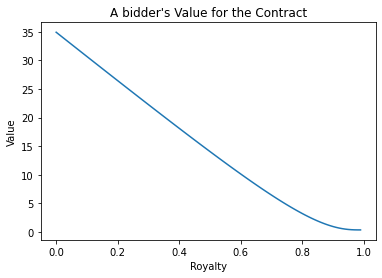

In [81]:
theta1 = 0.5
theta2 = 10
r = 0.05
t = 3
p = 100
sigma=0.5
agrids = np.arange(0, 1, 0.01)
values = [value(a, theta1, theta2, r, t, p, sigma) for a in agrids]
plt.title('A bidder\'s Value for the Contract')
plt.xlabel('Royalty')
plt.ylabel('Value')
plt.plot(agrids, values)

### Compute the Optimal Cash-Royalty Bidding

Given his type $\left(\theta_{1 i}, \theta_{2 i}\right)$, bidder $i$ chooses his bid $\left(a_i, b_i\right)$ to maximize his expected utility from the auction given his winning probability $P\left(\cdot, \cdot \mid \theta_{1 i}, \theta_{2 i}, n\right)$. His maximization problem is 
\begin{equation*}
\max _{a, b}\left[V\left(a ; \theta_{1 i}, \theta_{2 i}\right)-b\right] P\left(a, b \mid \theta_{1 i}, \theta_{2 i}, n\right)
\end{equation*}

We now omit the index $i$ for sake of simplicity. Differentiating with respect to $a$ and $b$, the first-order conditions give
$$
\begin{gathered}
V_a\left(a ; \theta_1, \theta_2\right)=-\frac{P_a\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)}, \\
V\left(a ; \theta_1, \theta_2\right)=b+\frac{P\left(a, b \mid \theta_1, \theta_2, n\right)}{P_b\left(a, b \mid \theta_1, \theta_2, n\right)} .
\end{gathered}
$$


#### Independent Private Values
I first consider the independent private values (IPV) case. I assume that $(\theta_{1i}, \theta_{2i})$ are i.i.d aross $i$. Nothe that this is different from the affliated private values (APV) model used by the original paper. APV allows correlation between $(\theta_{1i}, \theta_{2i})$ across samples. This paper finds high correlations between bidders (0.81 for production and 0.90 for cost), suggesting that APV is a better assumption.


The IPV assumption implies that the $P\left(\cdot, \cdot \mid \theta_{1}, \theta_{2}, n\right) = P\left(\cdot, \cdot \mid n\right)$, and $n = 2$ for each auction. The paper estimates this probablity from data, I will simplify the probability as follow.

26.466816063750862

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49])